In [1]:
import pandas as pd
import os 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from matplotlib  import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import joblib
import time
import random
from decile_analysis import *  # custom module for decile analysis 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import recall_score
from tabulate import tabulate
tab = lambda df : print(tabulate(df,headers = 'keys',tablefmt = 'psql'))


from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import NearestNeighbors 

from sklearn.cluster import DBSCAN 
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
df = pd.read_csv('data.csv')
df.columns = [i.lower() for i in df.columns]
pd.options.display.width=None

In [5]:
df.columns = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'target']

<AxesSubplot:>

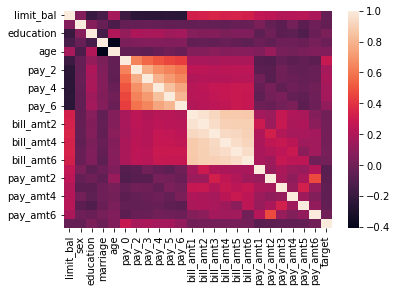

In [6]:
import seaborn as sns
corr  = df.corr()
sns.heatmap(corr)

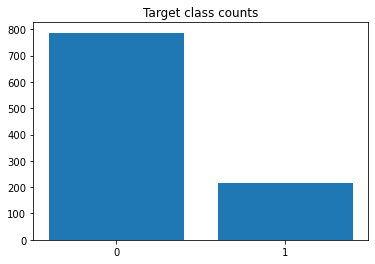

X_train shape : (1259, 23)
y_train shape : (1259,)
X_test shape : (315, 23)
y_test shape : (315,)


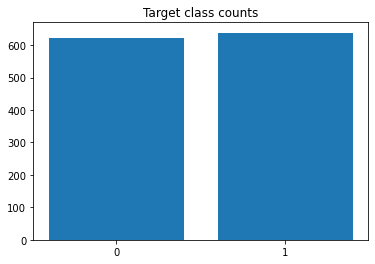

In [13]:
data = df
        
selected_features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
target = 'default payment next month'
X = data[selected_features]
y = data['default payment next month']

plt.title('Target class counts')
classes = y.value_counts().index
counts = y.value_counts()
plt.bar(x =classes,height = counts)
plt.xticks(classes)
plt.show()

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size=0.2)
print('X_train shape :',X_train.shape)
print('y_train shape :',y_train.shape)
print('X_test shape :',X_test.shape)
print('y_test shape :',y_test.shape)


plt.title('Target class counts')
classes = y_train.value_counts().index
counts = y_train.value_counts()
plt.bar(x =classes,height = counts)
plt.xticks(classes)
plt.show()

In [7]:
len(X_train.columns)

23

In [8]:
# scaling X_train using robustscaler 
transformer = RobustScaler().fit(X_train)
X_train = pd.DataFrame(transformer.transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(transformer.transform(X_test),columns = X_test.columns)

In [9]:
# gassian mixture model
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=5, random_state=0).fit(X_train)
gm_labels = gm.predict(X_train)

Text(0, 0.5, 'WCSS')

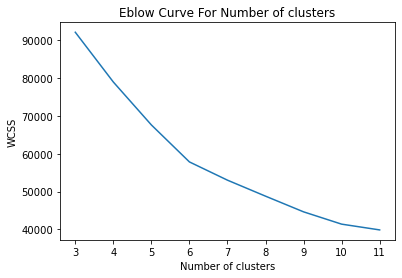

In [11]:
# K Means features 
from sklearn.cluster import KMeans
wcss = [] 
for i in range(3, 12): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_train) 
    wcss.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.title('Eblow Curve For Number of clusters')
plt.plot(range(3,12), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [24]:
k = 6
kmeans = KMeans(n_clusters = k)
kmeans_clusters = kmeans.fit_predict(X_train)

In [25]:
## Adding Unsupervised feature labels 
X_train['kmeans_labels'] = kmeans_clusters 
X_train['gm_labels'] = gm_labels 

In [26]:
# creating an aggregated value for bill_amt and pay_amt for training and testing features 
def aggregate_cols(cols,df):
    aggregated = []
    for i in range(len(df[cols])):
        agg_sum = df[cols].iloc[i].sum()
        aggregated.append(agg_sum)
    return aggregated 
                   
def standardize(col,col2 = None):
    if col2:
        mean = np.mean(col2)
        std = np.std(col2)
        col = [(i-mean)/std for i in col]
    else:
        mean = np.mean(col)
        std = np.std(col)
        col = [(i-mean)/std for i in col]
    
    return col
bill_cols = [i for i in df.columns if i.startswith('bill_amt')]
bill_aggregated = standardize(aggregate_cols(bill_cols,X_train))
    
pay_cols = [i for i in df.columns if i.startswith('pay_amt')]
pay_aggregated = standardize(aggregate_cols(pay_cols,X_train))

In [27]:
X_train['pay_aggregated'] = pay_aggregated 
X_train['bill_aggregated'] = bill_aggregated

In [28]:
X_train

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,kmeans_labels,gm_labels,pay_aggregated,bill_aggregated
0,0.806661,0.0,-1.0,0.0,0.692308,-1.0,-2.0,-2.0,-2.0,-2.0,...,0.214080,0.885318,1.005253,0.558938,0.563818,0.542517,0,0,-0.101631,-0.570597
1,0.722222,0.0,-1.0,1.0,0.769231,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.480460,-0.373031,-0.244911,-0.227693,-0.232034,-0.227191,0,0,-0.470593,-0.609229
2,2.055556,1.0,-1.0,0.0,0.000000,-2.0,-2.0,-2.0,-1.0,-1.0,...,-0.531609,0.251733,0.062049,0.037899,0.012871,4.832381,0,0,-0.042162,-0.598624
3,-0.444444,0.0,1.0,0.0,1.769231,3.0,2.0,0.0,0.0,0.0,...,-0.571264,0.031506,-0.184504,-0.172784,-0.184126,-0.134487,0,2,-0.432758,-0.425601
4,-0.611111,0.0,0.0,0.0,0.230769,0.0,0.0,0.0,0.0,0.0,...,-0.108908,0.472590,-0.130991,-0.120263,-0.100465,-0.075078,0,2,-0.356210,-0.357842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,-0.444444,1.0,0.0,0.0,1.153846,0.0,0.0,0.0,0.0,0.0,...,-0.107759,0.157530,0.143795,0.274843,0.189489,0.016974,0,2,-0.307195,-0.158738
1255,-0.555556,1.0,0.0,1.0,-0.538462,-1.0,-1.0,2.0,0.0,-1.0,...,0.329885,-0.472590,-0.348654,8.543718,-0.398641,0.184103,0,4,0.168546,-0.220673
1256,0.929294,0.0,-1.0,1.0,-0.153846,1.0,-2.0,-1.0,0.0,-1.0,...,-0.571264,2.506616,-0.348654,3.931364,-0.346085,-0.330341,0,4,-0.030452,-0.532906
1257,-0.277778,0.0,-1.0,1.0,0.076923,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.573276,1.686515,0.215693,0.089227,6.731141,0.458952,0,0,0.295866,-0.515936


In [29]:
# preprocessing X_test
test_kmeans_labels = kmeans.predict(X_test)
test_gm_labels = gm.predict(X_test)
X_test['kmeans_labels'] = test_kmeans_labels
X_test['gm_labels'] = test_gm_labels

# while transforming X_test we wont fit ( using the existting mean and std) 
bill_aggregated = standardize(aggregate_cols(bill_cols,X_test),aggregate_cols(bill_cols,X_train))
pay_aggregated = standardize(aggregate_cols(pay_cols,X_test),aggregate_cols(bill_cols,X_train))

X_test['pay_aggregated'] = pay_aggregated 
X_test['bill_aggregated'] = bill_aggregated

In [30]:
X_test

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,kmeans_labels,gm_labels,pay_aggregated,bill_aggregated
0,0.496444,0.0,-1.0,0.0,0.615385,1.0,-2.0,-1.0,-1.0,-2.0,...,-0.571264,-0.422495,-0.348654,-0.321993,-0.398641,-0.330341,0,0,-0.653046,-0.613706
1,-0.444444,0.0,-1.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,...,-0.247414,-0.134216,-0.278070,-0.247687,1.168395,-0.274196,0,2,-0.385285,-0.439798
2,-0.277778,1.0,1.0,1.0,0.076923,0.0,-1.0,0.0,0.0,0.0,...,3.020690,1.575299,0.636244,0.274843,0.673936,0.322507,0,4,0.347813,-0.315691
3,0.132961,1.0,2.0,1.0,0.692308,0.0,0.0,-1.0,0.0,0.0,...,-0.326437,-0.164146,-0.323047,-0.321993,-0.384698,-0.304880,0,0,-0.589128,-0.595943
4,-0.055556,1.0,0.0,1.0,-0.692308,2.0,2.0,2.0,2.0,2.0,...,0.580172,-0.472590,2.367039,1.170098,-0.398641,1.105925,0,4,0.105778,1.042208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,-0.444444,0.0,0.0,1.0,-0.846154,1.0,2.0,2.0,2.0,0.0,...,-0.283908,2.678009,-0.217334,-0.113101,-0.112621,-0.134487,0,4,-0.179447,-0.376386
311,-0.444444,0.0,0.0,1.0,-0.153846,2.0,0.0,0.0,0.0,0.0,...,-0.072989,0.000000,-0.014773,-0.018502,-0.037183,-0.081932,0,2,-0.409156,-0.253994
312,0.166667,1.0,0.0,1.0,-0.692308,-2.0,-2.0,-2.0,-2.0,-2.0,...,-0.571264,-0.472590,-0.348654,-0.321993,-0.398641,-0.330341,0,0,-0.658682,-0.614062
313,0.166667,0.0,-1.0,0.0,0.538462,0.0,-1.0,0.0,0.0,2.0,...,3.829598,4.253308,0.636244,-0.321993,0.673936,-0.330341,0,4,0.599491,-0.166521


In [33]:
# Modelling 
models = [RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,
              LinearDiscriminantAnalysis,SVC,LogisticRegression]
random.seed(121)
def Model_training(models):
    random.seed(121)
    y_test_preds = {}
    training_scores = {}
    testing_scores = {}
    testing_recall_scores = {}
    training_recall_scores = {}
    for model in models:
        m = model()
        m.fit(X_train,y_train)
        y_pred_test = m.predict(X_test)
        y_pred_train = m.predict(X_train)
        

        # average scores 
        training_score = m.score(X_train,y_train)
        testing_score = m.score(X_test,y_test)
        training_scores[model.__name__] = training_score
        testing_scores[model.__name__] = testing_score
        
        
        # recall measures 
        training_recall = recall_score(y_train,y_pred_train)
        testing_recall = recall_score(y_test,y_pred_test)
        
    
        training_recall_scores[model.__name__] = training_recall
        testing_recall_scores[model.__name__] = testing_recall
    
    measurements = pd.DataFrame()
    measurements.index = training_scores.keys()
    measurements['training_scores'] = training_scores.values()
    measurements['testing_scores'] = testing_scores.values()
    measurements['training_recalls'] = training_recall_scores.values()
    measurements['testing_recalls'] = testing_recall_scores.values()
    
    return measurements

In [34]:
random.seed(1)
evaluation_metrics = Model_training(models)
tab(evaluation_metrics)

+----------------------------+-------------------+------------------+--------------------+-------------------+
|                            |   training_scores |   testing_scores |   training_recalls |   testing_recalls |
|----------------------------+-------------------+------------------+--------------------+-------------------|
| RandomForestClassifier     |          1        |         0.863492 |           1        |          0.879195 |
| GradientBoostingClassifier |          0.915012 |         0.803175 |           0.899687 |          0.825503 |
| AdaBoostClassifier         |          0.810961 |         0.784127 |           0.821317 |          0.838926 |
| LinearDiscriminantAnalysis |          0.73471  |         0.742857 |           0.758621 |          0.724832 |
| SVC                        |          0.750596 |         0.771429 |           0.80094  |          0.798658 |
| LogisticRegression         |          0.738681 |         0.742857 |           0.755486 |          0.731544 |
+

In [15]:
# Removing some features 
selected_features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'kmeans_labels', 'gm_labels', 'pay_aggregated', 'bill_aggregated']
target = 'default payment next month'
X_train = X_train[selected_features]
X_test = X_test[selected_features]
X_train

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,kmeans_labels,gm_labels,pay_aggregated,bill_aggregated
0,0.444444,1.0,-1.0,0.0,0.538462,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,0,-0.467404,-0.632017
1,0.722222,0.0,-1.0,1.0,0.769231,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,0,-0.481013,-0.633477
2,2.055556,1.0,-1.0,0.0,0.000000,-2.0,-2.0,-2.0,-1.0,-1.0,-1.0,1,3,-0.044555,-0.622170
3,-0.444444,0.0,1.0,0.0,1.769231,3.0,2.0,0.0,0.0,0.0,0.0,1,0,-0.441146,-0.440709
4,-0.611111,0.0,0.0,0.0,0.230769,0.0,0.0,0.0,0.0,0.0,0.0,1,0,-0.362683,-0.369407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,-0.444444,1.0,0.0,0.0,1.153846,0.0,0.0,0.0,0.0,0.0,0.0,1,0,-0.312503,-0.161277
1255,-0.555556,1.0,0.0,1.0,-0.538462,-1.0,-1.0,2.0,0.0,-1.0,2.0,1,3,0.198064,-0.226483
1256,-0.400144,1.0,-1.0,1.0,-0.846154,2.0,3.0,2.0,2.0,2.0,2.0,1,0,-0.362270,-0.163265
1257,-0.277778,0.0,-1.0,1.0,0.076923,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,3,0.294812,-0.535641


In [17]:
random.seed(1)
evaluation_metrics = Model_training(models)
tab(evaluation_metrics)

+----------------------------+-------------------+------------------+--------------------+-------------------+
|                            |   training_scores |   testing_scores |   training_recalls |   testing_recalls |
|----------------------------+-------------------+------------------+--------------------+-------------------|
| RandomForestClassifier     |          1        |         0.834921 |           1        |          0.852349 |
| GradientBoostingClassifier |          0.880858 |         0.787302 |           0.866771 |          0.758389 |
| AdaBoostClassifier         |          0.772041 |         0.75873  |           0.766458 |          0.744966 |
| LinearDiscriminantAnalysis |          0.743447 |         0.742857 |           0.744514 |          0.731544 |
| SVC                        |          0.799047 |         0.75873  |           0.819749 |          0.765101 |
| LogisticRegression         |          0.748213 |         0.736508 |           0.752351 |          0.704698 |
+

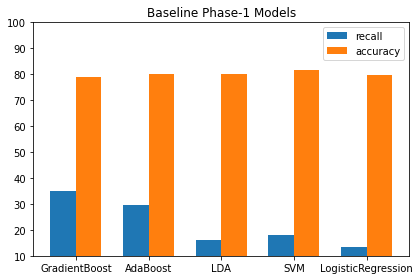

In [18]:
import matplotlib.pyplot as plt
import numpy as np
# first phase baseline results 
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame()
df['accuracy'] = [79.1,80.01,80.01,81.59,79.6]
df['recall'] = [35.13,29.7,16.21,18.2,13.5]

labels  = ['GradientBoost','AdaBoost','LDA','SVM','LogisticRegression']

recall = df['recall']
accuracy = df['accuracy']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, recall, width, label='recall')
rects2 = ax.bar(x + width/2, accuracy, width, label='accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Baseline Phase-1 Models')
ax.legend()
plt.xticks(range(0,len(labels)), labels)
plt.ylim(10,100)
fig.tight_layout()

plt.show()

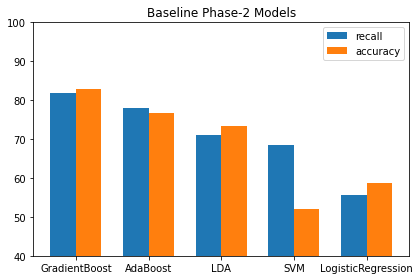

In [15]:
import matplotlib.pyplot as plt
import numpy as np
# first phase baseline results 
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame()
df['recall'] = [81.8,77.9,71.1,68.4,55.7]
df['accuracy'] = [82.8,76.8,73.3,52.06,58.7]

labels  = ['GradientBoost','AdaBoost','LDA','SVM','LogisticRegression']

recall = df['recall']
accuracy = df['accuracy']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, recall, width, label='recall')
rects2 = ax.bar(x + width/2, accuracy, width, label='accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Baseline Phase-2 Models')
ax.legend()
plt.xticks(range(0,len(labels)), labels)
plt.ylim(40,100)
fig.tight_layout()

plt.show()

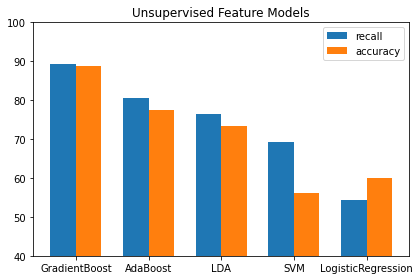

In [16]:
import matplotlib.pyplot as plt
import numpy as np
# first phase baseline results 
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame()
df['recall'] = [89.4,80.5,76.5,69.23,54.4]
df['accuracy'] = [88.8,77.4,73.3,56.19,60]

labels  = ['GradientBoost','AdaBoost','LDA','SVM','LogisticRegression']

recall = df['recall']
accuracy = df['accuracy']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, recall, width, label='recall')
rects2 = ax.bar(x + width/2, accuracy, width, label='accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Unsupervised Feature Models')
ax.legend()
plt.xticks(range(0,len(labels)), labels)
plt.ylim(40,100)
fig.tight_layout()

plt.show()